In [0]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
path = '/content/drive/My Drive/datasets/facial-expression/fer2013/fer2013-balanced-new.csv'
fer_dataset = pd.read_csv(path)

Text(0.5, 1.0, 'Data partitioning')

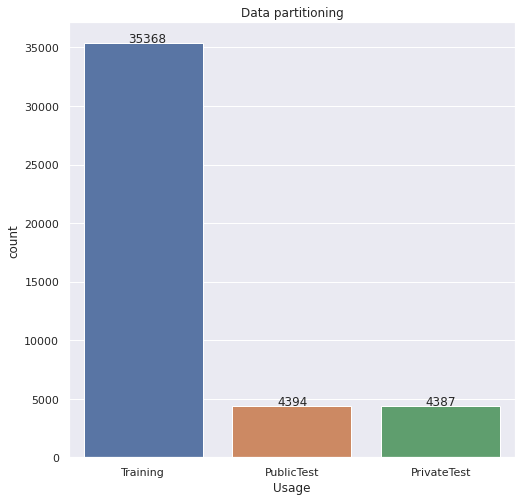

In [74]:
# In order to check how data is partitioned we're going to do a counter plot
# The PublicTest will be used for validation
# The PrivateTest will be used for testing
plt.figure(figsize = (8,8))
sns.set(style="darkgrid")
ax = sns.countplot(fer_dataset['Usage'], label='Count')
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+50))
plt.title('Data partitioning')

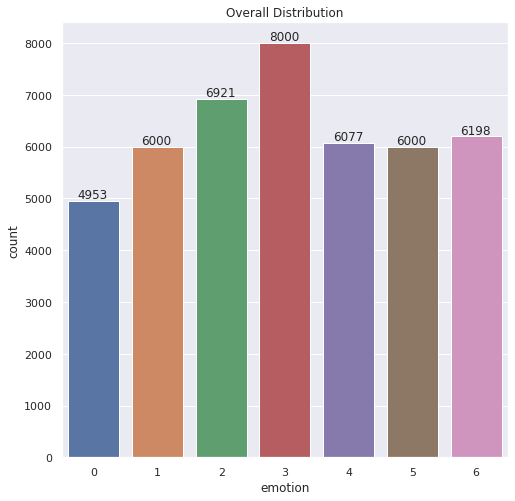

0 = Angry
1 = Disgust
2 = Fear
3 = Happy
4 = Sad
5 = Surprise
6 = Neutral


In [76]:
# Get the distribution of the data before augmentation
plt.figure(figsize = (8,8))
sns.set(style="darkgrid")
ax = sns.countplot(fer_dataset['emotion'], label='Count')
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+50))
plt.title('Overall Distribution')
plt.show()
print('0 = Angry\n1 = Disgust\n2 = Fear\n3 = Happy\n4 = Sad\n5 = Surprise\n6 = Neutral')

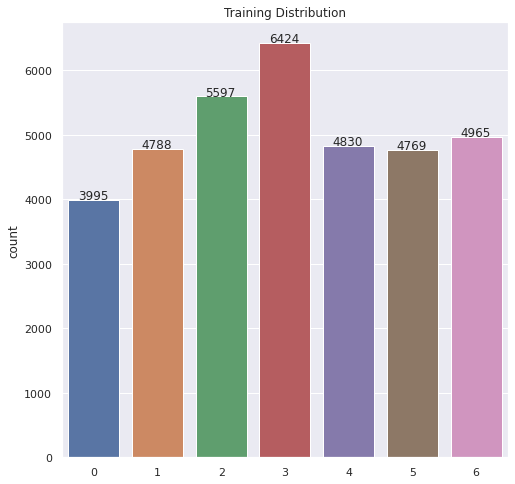

In [83]:
plt.figure(figsize = (8,8))
sns.set(style="darkgrid")
ax = sns.countplot(y_train, label='Count')
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+10))
plt.title('Training Distribution')
plt.show()

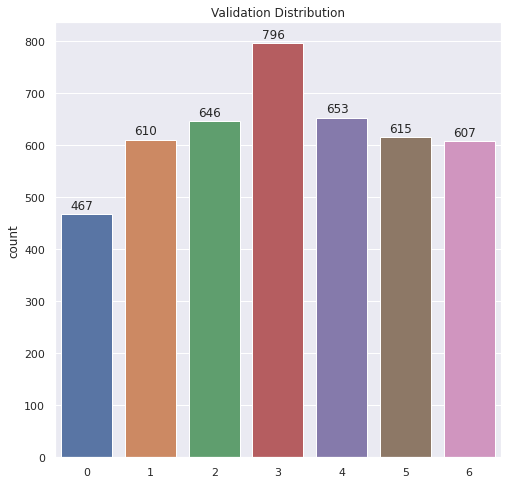

In [84]:
plt.figure(figsize = (8,8))
sns.set(style="darkgrid")
ax = sns.countplot(y_val, label='Count')
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+10))
plt.title('Validation Distribution')
plt.show()

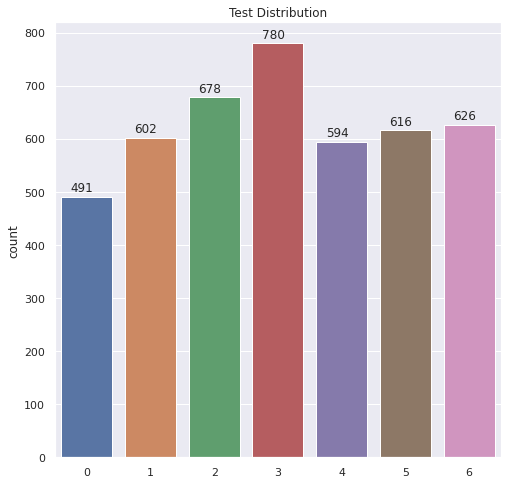

In [86]:
plt.figure(figsize = (8,8))
sns.set(style="darkgrid")
ax = sns.countplot(y_test, label='Count')
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+10))
plt.title('Test Distribution')
plt.show()

In [0]:
# The function for getting the pixels as a list 
# input_set: dataset 
# @return: an array of flattened images
def getPixels(input_set):
  pixels = input_set['pixels'].tolist()
  new_pixels = []
  for pixel_sequence in pixels:
    image = [int(pixel) for pixel in pixel_sequence.split(' ')]
    new_pixels.append(image)
  return np.asarray(new_pixels, dtype='float32')

# The function for reshpping the dataset
# input_set: dataset with only pixels (# the return of the getPixels(input_set))
def reshapeDataset(input_set):
  new_input_set = []
  for image in input_set:
    # reshape the image in (48, 48) shape
    image = image.reshape((48, 48))

    # add new axis for being in (48, 48, 1) shape
    image = image[:, :, np.newaxis]

    # reshape in (48, 48, 3) shape by concatenating 3 times the image
    # image = np.concatenate((image, image, image), axis=2)
    new_input_set.append(image)
  return np.asarray(new_input_set, dtype='float32')

# This function is going to help with normalizing and reshapping a set
def reshape_set(input_set):
  images = getPixels(input_set)
  print('Done with pixels of images')

  reshapped_images = reshapeDataset(images)
  print('Done reshaping the images')

  return reshapped_images

In [78]:
# We want to preparing the data set for normalizing part

# 1. Split the data frame for training, data for validation,data for testing
data_for_training = fer_dataset[fer_dataset['Usage'] == 'Training']

data_for_validation = fer_dataset[fer_dataset['Usage'] == 'PublicTest']
data_for_testing = fer_dataset[fer_dataset['Usage'] == 'PrivateTest']

# Print the shape of the sets
print('Train shape = ',data_for_training.shape)
print('Validation shape = ',data_for_validation.shape)
print('Test shape = ',data_for_testing.shape)

Train shape =  (35368, 3)
Validation shape =  (4394, 3)
Test shape =  (4387, 3)


In [0]:
# 2. Drop the column Usage from train, validation and test sets
data_for_training = data_for_training.drop(['Usage'],axis=1)
data_for_validation = data_for_validation.drop(['Usage'],axis=1)
data_for_testing = data_for_testing.drop(['Usage'],axis=1)

In [0]:
# 3. Split the data in X and y format; 
#    X stands for the column 'pixels' from original dataframe and y stands for column 'emotion' from original dataset
#    The partitioning will be: X_train, y_train, X_validation, y_validation, X_test, y_test

X_train = reshape_set(data_for_training)
X_val = reshape_set(data_for_validation)
X_test = reshape_set(data_for_testing)

y_train = np.asarray(data_for_training['emotion'], dtype='int64')
y_val = np.asarray(data_for_validation['emotion'], dtype='int64')
y_test = np.asarray(data_for_testing['emotion'], dtype='int64')

In [81]:
# Let's check the shape of every set
print('X_train = ',X_train.shape)
print('X_val = ', X_val.shape)
print('X_test = ', X_test.shape)

X_train =  (35368, 48, 48, 1)
X_val =  (4394, 48, 48, 1)
X_test =  (4387, 48, 48, 1)


In [0]:
# Function for making data augmentation on a set of images
# images: images on which we apply data augmentation in (48, 48) format
# transformation: what kind of transformation should be applied
# return: augmented images
def makeDataAugmentation(images, transformation, transformationValue):
  gen = ImageDataGenerator()
  augmented_images = []
  for i in range(len(images)):
    # Get the image
    image = images[i]

    # Apply transformation to the image
    augmented_image = gen.apply_transform(image,{transformation: transformationValue})

    # Save the image
    augmented_images.append(augmented_image)
  return np.asarray(augmented_images)

In [0]:
# Function which get the whole images on a specific class
# numberOfImages: How many images we want from a certain class
def get_image_class(x,y,class_code, numberOfImages=None):
  if numberOfImages == None:
    return np.asarray([x[i] for i in range(len(y)) if y[i] == class_code])
  else:
    images_of_class = [x[i] for i in range(len(y)) if y[i] == class_code]
    return np.asarray(images_of_class[:numberOfImages])

In [0]:
# A function which writes iamges to a csv file
# images: which should be write in (48, 48) format
# pathToCSV: path to csv where should save the imasges
# class_code: the class code of the images 
# Usage: the usage of images (Traininig, PublicTest, PrivateTest)
def writeImagesToCSV(images, pathToCSV, class_code, usage):
  for i in range(len(images)):
    image = images[i]

    # Flattening the image
    image = image.reshape(image.shape[0]*image.shape[1])

    # Transform the pixels into strings
    string_image =' '.join([str(int(pixel)) for pixel in image]) 

    # Write to csv the image with the label 
    with open(pathToCSV, mode='a') as images_file:
      images_writer = csv.writer(images_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      images_writer.writerow([class_code, string_image, usage])
    print('Done with image ' + str(i) +'on the ' + usage)

In [0]:
# A function for making data augmentation on a class of images for a certain set (Train, validation, test)
def dataAugmentationOnClass(x,y,class_code, usage, transformation, transformationValue, numberOfImages,pathToCSV):
  images_of_class = get_image_class(x,y,class_code,numberOfImages)
  print('Done get images of class ' + str(class_code))

  augmented_images = makeDataAugmentation(images_of_class,transformation, transformationValue)
  print('Done augmented images of class ' + str(class_code))

  writeImagesToCSV(augmented_images, pathToCSV, class_code, usage)


In [0]:
# Horizontal Flip on Training class_code = 1
# transformationValue = True
# transformation = 'flip_horizontal'
# dataAugmentationOnClass(X_train,y_train,1,'Training',transformation, transformationValue, path)

In [0]:
# Horizontal Flip on Validation class_code = 1
# transformationValue = True
# transformation = 'flip_horizontal'
# dataAugmentationOnClass(X_val,y_val,1,'PublicTest',transformation, transformationValue, path)

In [0]:
# Horizontal Flip on Testing class_code = 1
# transformationValue = True
# transformation = 'flip_horizontal'
# dataAugmentationOnClass(X_test,y_test,1,'PrivateTest',transformation, transformationValue, path)

In [0]:
# Rotation range on Training class_code = 1
# transformationValue = 30
# transformation = 'theta'
# dataAugmentationOnClass(X_train,y_train,1,'Training',transformation, transformationValue, path)

In [0]:
# Rotation range on Validation class_code = 1
# transformationValue = 30
# transformation = 'theta'
# dataAugmentationOnClass(X_val,y_val,1,'PublicTest',transformation, transformationValue, path)

In [0]:
# Rotation range on Testing class_code = 1
# transformationValue = 30
# transformation = 'theta'
# dataAugmentationOnClass(X_test,y_test,1,'PrivateTest',transformation, transformationValue, path)

In [0]:
# Brightness on Training class_code = 1
# transformationValue = 1.2
# transformation = 'brightness'
# dataAugmentationOnClass(X_train,y_train,1,'Training',transformation, transformationValue, path)

In [0]:
# Brightness on Validation class_code = 1
# transformationValue = 1.2
# transformation = 'brightness'
# dataAugmentationOnClass(X_val,y_val,1,'PublicTest',transformation, transformationValue, path)

In [0]:
# Brightness on Testing class_code = 1
# transformationValue = 1.2
# transformation = 'brightness'
# dataAugmentationOnClass(X_test,y_test,1,'PrivateTest',transformation, transformationValue, path)

In [0]:
# GENERATE 1624 MORE IMAGES OVERALL class_code = 1
# Shift in the y direction on Training class_code = 1
# transformationValue = 5
# transformation = 'ty'
# numberOfImages = 1300
# dataAugmentationOnClass(X_train,y_train,1,'Training',transformation, transformationValue, numberOfImages,path)

In [0]:
# Shift in the y direction on Validation class_code = 1
# transformationValue = 5
# transformation = 'ty'
# numberOfImages = 162
# dataAugmentationOnClass(X_val,y_val,1,'PublicTest',transformation, transformationValue, numberOfImages,path)

In [0]:
# Shift in the y direction on Testing class_code = 1
# transformationValue = 5
# transformation = 'ty'
# numberOfImages = 162
# dataAugmentationOnClass(X_test,y_test,1,'PrivateTest',transformation, transformationValue, numberOfImages,path)

In [0]:
# GENERATE 1800 more images on Training class_code = 2
# transformationValue = True
# transformation = 'flip_horizontal'
# numberOfImages = 1500
# class_code = 2
# dataAugmentationOnClass(X_train,y_train,class_code,'Training',transformation, transformationValue, numberOfImages,path)

In [0]:
# GENERATE 150 more images on Validation class_code = 2
# transformationValue = True
# transformation = 'flip_horizontal'
# numberOfImages = 150
# class_code = 2
# dataAugmentationOnClass(X_val,y_val,class_code,'PublicTest',transformation, transformationValue, numberOfImages,path)

In [0]:
# GENERATE 150 more images on Testing class_code = 2
# transformationValue = True
# transformation = 'flip_horizontal'
# numberOfImages = 150
# class_code = 2
# dataAugmentationOnClass(X_test,y_test,class_code,'PrivateTest',transformation, transformationValue, numberOfImages,path)

In [0]:
#GENERATE 1998 more image on Training class_code = 5
# transformationValue = True
# transformation = 'flip_horizontal'
# numberOfImages = 1598
# class_code = 5
# dataAugmentationOnClass(X_train,y_train,class_code,'Training',transformation, transformationValue, numberOfImages,path)

In [0]:
# GENERATE 200 more image on Validation class_code = 5
# transformationValue = True
# transformation = 'flip_horizontal'
# numberOfImages = 200
# class_code = 5
# dataAugmentationOnClass(X_val,y_val,class_code,'PublicTest',transformation, transformationValue, numberOfImages,path)

In [0]:
# GENERATE 200 more image on Testing class_code = 5
# transformationValue = True
# transformation = 'flip_horizontal'
# numberOfImages = 200
# class_code = 5
# dataAugmentationOnClass(X_test,y_test,class_code,'PrivateTest',transformation, transformationValue, numberOfImages,path)

In [0]:
# A function for getting the names of indexes from data frame 
# emotion: for what emotion you want 
# usage: Training, PublicTest, PrivateTest
# return: an array of indexes
def get_indexes(df, emotion, usage):
  return df[ (df['emotion'] == emotion) &  (df['Usage'] == usage)].index 

In [0]:
# A function for removing a certain number of indexes from a dataframe
def remove_images(df, emotion, usage, numberOfImages):
  # get the names of indexes based on emotion and usage
  index_names = get_indexes(df, emotion, usage)

  # get only numberOfImages from the index_names
  index_names = index_names[:numberOfImages]

  # delete names of indexes
  df = df.drop(index_names)
  
  return df


In [0]:
# IN ORDER TO BALANCE THE DATASET WE NEED TO DELETE 989 images from class 3
# number of deleted images from training: 791
# number of deleted images from validation: 99
# number of deleted images from testing: 99

# class_code = 3

# # delete from training
# usage = 'Training'
# numberOfImagesTraining = 791
# new_fer = remove_images(fer_dataset, class_code,'Training',numberOfImagesTraining)

# # delete from validation
# usage = 'PublicTest'
# numberOfImagesValidation = 99
# new_fer = remove_images(new_fer, class_code,'PublicTest',numberOfImagesValidation)

# # delete from testing
# usage = 'PrivateTest'
# numberOfImagesTesting = 99
# new_fer = remove_images(new_fer, class_code,'PrivateTest',numberOfImagesTesting)

# new_fer.to_csv('/content/drive/My Drive/datasets/facial-expression/fer2013/fer2013-balanced-new.csv',index=False)

In [0]:
imgs = X_train[:1300]

In [71]:
imgs.shape

(1300, 48, 48, 1)

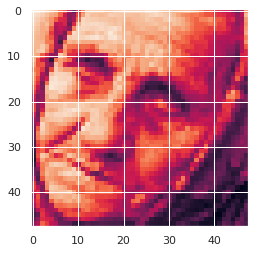

In [69]:
plt.imshow(imgs.reshape(48,48))

In [0]:
gen = ImageDataGenerator()

In [0]:
transformationimg = gen.apply_transform(img,{'ty': 5})

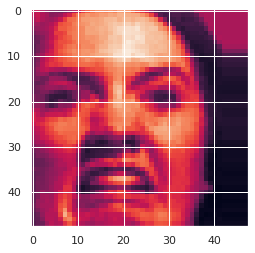

In [55]:
plt.imshow(transformationimg.reshape(48,48))